<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [19]</a>'.</span>

# Global PCA model training

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tikzplotlib
import random
import ast
import math
from nltk.corpus import stopwords
from gensim.utils import tokenize
from lyrics_stats import lyrics_statistics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import joblib
from gensim.models.doc2vec import Doc2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

2023-03-04 15:48:36.595833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-03-04 15:48:37.974871: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-04 15:48:37.975530: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-04 15:48:37.975541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
sns.set_theme(context='paper', style='white', palette='deep')

In [3]:
df = pd.read_csv('../data/lyrics.csv')

In [4]:
df.head()

,lyrics,genre,id
0,"['So long', 'My sweet love', 'I miss you', ""Mo...",pop,0
1,"[""It won't be long before I'm leaving here"", ""...",pop,1
2,"['Are we crazy?', 'Living our lives through a ...",pop,2
3,"['When did it go wrong, I will never know', 'I...",pop,3
4,"[""I've waited all this time"", 'Counting minute...",pop,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lyrics  36000 non-null  object
 1   genre   36000 non-null  object
 2   id      36000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 843.9+ KB


In [6]:
df['lyrics'] = df['lyrics'].apply(ast.literal_eval)

In [7]:
idxs_eval = pd.read_csv('../data/evaluation/lyrics_eval.csv')['id']

In [8]:
df = df.drop(idxs_eval)
df = df.reset_index()

In [9]:
lyrics = list(df['lyrics'])
genres = list(df['genre'])

verses = [verse for lyr in lyrics for verse in lyr]
genres_by_verse = [genre for lyr, genre in zip(lyrics, genres) for verse in lyr]

lyrics_indexes = [i for i, lyr in enumerate(lyrics) for verse in lyr]
verse_indexes = [i for lyr in lyrics for i, verse in enumerate(lyr)]

df_verse = pd.DataFrame({'verse': verses, 'genre': genres_by_verse, 
                         'lyrics_id': lyrics_indexes, 'verse_id': verse_indexes})

#df_verse = df_verse.groupby('genre').sample(frac=0.05, random_state=42).reset_index()
#df_verse = df_verse.groupby('genre').sample(n=25, random_state=42).reset_index()

In [10]:
opening_verse = df_verse.loc[df_verse.groupby('lyrics_id')['verse_id'].idxmin()]
final_verse = df_verse.loc[df_verse.groupby('lyrics_id')['verse_id'].idxmax()]
middle_verse = df_verse.groupby('lyrics_id')['verse_id'].apply(lambda x: x.iloc[math.ceil(len(x)/2)-1]).reset_index()[['lyrics_id', 'verse_id']]

In [11]:
df_verse = pd.concat([opening_verse, final_verse, middle_verse]).reset_index(drop=True)

## Features

In [12]:
# Get features from a specific verse based on its index in the lyrics
def get_features_verse(lyrics_features, verse_idx):
    return [lyrics_features[verse_idx] for lyrics_features in lyrics_features.values()]

# Compute lyrics statistics of lyrics with index_id i, get verse statistics from verse_id j
features_by_verse = [get_features_verse(lyrics_statistics(df['lyrics'][row['lyrics_id']]), row['verse_id']) 
                    for index, row in df_verse.iterrows()]

features_by_verse = np.array(features_by_verse)

In [13]:
scaler = StandardScaler()
scl_features_by_verse = scaler.fit_transform(np.array(features_by_verse))

In [14]:
pca = PCA(n_components=1, random_state=42)
pca.fit(scl_features_by_verse)

PCA(n_components=1, random_state=42)

In [15]:
joblib.dump(pca, '../models/gpca/features_pca.pkl')
joblib.dump(scaler, '../models/gpca/features_scaler.pkl')

['../models/gpca/features_scaler.pkl']

In [16]:
scaler = joblib.load('../models/gpca/features_scaler.pkl')
pca = joblib.load('../models/gpca/features_pca.pkl')

['Answer me', 'Oh my love', 'Just what sin have I been guilty of', 'Tell me how I came to lose your love', 'Please answer me sweetheart', 'You were mine yesterday', 'I believed that love was here to stay', "Won't you tell me how I've gone astray", 'Please answer me my love', "If you're happier without me", "I'll try not to care", 'But if you still think about me', 'Please listen to my prayer', "You must know that I've been true", "Won't you say that we can start anew", 'In my sorrow now I turn to you', 'Please answer me my love', "If you're happier without me", "I'll try not to care", 'But if you still think about me', 'Please listen to my prayer', "You must know that I've been true", "Won't you say that we can start anew", 'In my sorrow now I turn to you', 'Please answer me my love', 'Answer me my love']


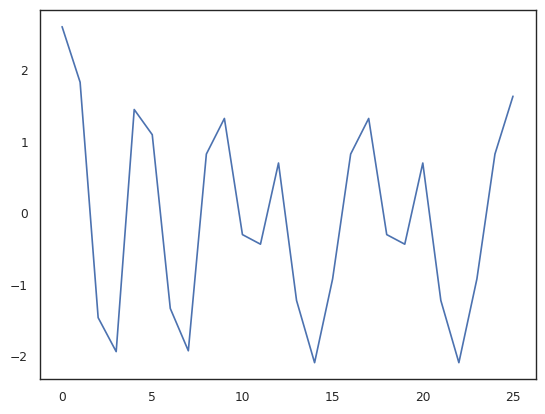

In [17]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

eg_multi_ts = pd.DataFrame(lyrics_statistics(random_lyrics)).values
eg_scl_multi_ts = scaler.transform(eg_multi_ts)
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_scl_multi_ts)))
plt.plot(eg_uni_ts)

## Sentence BERT

In [18]:
model = SentenceTransformer('all-MiniLM-L6-v2')

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [19]:
embeddings = df_verse['verse'].apply(lambda x: model.encode([x]))
embeddings = np.concatenate(embeddings, axis=0)

TypeError: 'float' object is not subscriptable

In [ ]:
pca = PCA(n_components=1, random_state=42)
pca.fit(embeddings)

In [ ]:
joblib.dump(pca, '../models/gpca/sbert_pca.pkl')

In [ ]:
pca = joblib.load('../models/gpca/sbert_pca.pkl')

In [ ]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

eg_multi_ts = np.array([model.encode(verse) for verse in random_lyrics])
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)

## Doc2Vec

In [ ]:
model = Doc2Vec.load("../models/d2v/doc2vec.model")

In [ ]:
tokenized_verses = df_verse['verse'].apply(lambda x: list(tokenize(x, lowercase=True)))

In [ ]:
embeddings = np.array([model.infer_vector(verse) for verse in tokenized_verses if verse])

In [ ]:
scaler = StandardScaler()
scl_embeddings = scaler.fit_transform(embeddings)

In [ ]:
pca = PCA(n_components=1, random_state=42)
pca.fit(scl_embeddings)

In [ ]:
joblib.dump(pca, '../models/gpca/d2v_pca.pkl')
joblib.dump(scaler, '../models/gpca/d2v_scaler.pkl')

In [ ]:
scaler = joblib.load('../models/gpca/d2v_scaler.pkl')
pca = joblib.load('../models/gpca/d2v_pca.pkl')

In [ ]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

tokenized_lyrics = [list(tokenize(verse, lowercase=True)) for verse in random_lyrics]
    
eg_multi_ts = np.array([model.infer_vector(verse) for verse in tokenized_lyrics])
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)

## Emotion

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", output_hidden_states = False)

In [ ]:
def get_logits(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits    
    return logits

In [ ]:
def logits2label(logits, model):
    predicted_class_id = logits.argmax().item()
    label = model.config.id2label[predicted_class_id]
    return label

In [ ]:
logits_tensor = df_verse['verse'].apply(get_logits, tokenizer=tokenizer, model=model)

In [ ]:
# Convert tensors to numpy array
logits = np.array([lt[0].numpy() for lt in logits_tensor])
labels = [logits2label(lt, model) for lt in logits_tensor]

In [ ]:
tsne_model = TSNE(n_components=2, random_state=42, init='pca')

In [ ]:
tsne_logits = pd.DataFrame(tsne_model.fit_transform(logits), columns=['x','y'])
tsne_logits['label'] = labels

In [ ]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=tsne_logits, x='x', y='y', hue='label')
ax.set_title('T-SNE representation of emotion logits')
tikzplotlib.save('../tikz/tsne_emotions.tex')

In [ ]:
scaler = StandardScaler()
scl_logits = scaler.fit_transform(logits)

In [ ]:
pca = PCA(n_components=1, random_state=42)
pca.fit(scl_logits)

In [ ]:
joblib.dump(pca, '../models/gpca/emo_pca.pkl')
joblib.dump(scaler, '../models/gpca/emo_scaler.pkl')

In [ ]:
scaler = joblib.load('../models/gpca/emo_scaler.pkl')
pca = joblib.load('../models/gpca/emo_pca.pkl')

In [ ]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

logits_tensor = [get_logits(verse, tokenizer=tokenizer, model=model) for verse in random_lyrics]

# Convert tensors to numpy array
eg_multi_ts = np.array([lt[0].numpy() for lt in logits_tensor])
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)